import packages

In [ ]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.utils as utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

## Data Manipulation

In [ ]:
import torchvision.transforms as transforms
compose = transforms.Compose([
    transforms.CenterCrop((200,330)),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
data_dir = '/content/drive/MyDrive/dataset/spec/'
dataset = torchvision.datasets.ImageFolder(data_dir,transform=compose)

In [ ]:
len(dataset)

1190

train / test 나누기: test set는 200개로 CV 할 때마다 성능 검사

In [ ]:
from torch.utils.data import random_split
seed_everything(42)
train_data, test_data = random_split(dataset,[990,200])

In [ ]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle =True)

In [ ]:
num=[]
for _, test_target in testloader:
  num += test_target
print(sum(num))

tensor(111)


5-fold로 데이터 나누기

In [ ]:
from sklearn.model_selection import KFold
from torch.utils import data

seed_everything(12)
folds = KFold(n_splits=5,shuffle=True)
train = []
valid = []

for i_fold, (train_idx, valid_idx) in enumerate(folds.split(train_data)):
    dataset_train = data.Subset(train_data, train_idx)
    dataset_valid = data.Subset(train_data, valid_idx)
    trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=10, shuffle =True)
    train.append(trainloader)
    validloader = torch.utils.data.DataLoader(dataset_valid, batch_size=10, shuffle=True)
    valid.append(validloader)

In [ ]:
for i_fold, (train_idx, valid_idx) in enumerate(folds.split(train_data)):
  print(i_fold)
  print('train',valid_idx)

0
train [  4   7  13  15  16  20  34  38  43  54  61  75  77  89  90  97  98 101
 111 115 116 117 120 122 131 133 153 161 163 164 167 175 177 178 183 187
 190 191 194 196 206 207 213 216 218 221 226 229 242 248 249 252 268 270
 274 277 278 282 283 289 296 301 303 313 321 326 330 338 343 344 347 350
 351 352 353 355 362 363 369 371 377 379 381 388 390 391 401 404 405 408
 410 415 416 421 431 433 440 459 465 467 468 471 473 474 475 476 483 492
 500 501 502 508 519 525 535 543 545 552 570 571 579 581 592 594 596 605
 606 613 627 632 633 639 647 649 661 665 667 669 671 674 676 677 691 694
 700 710 721 727 730 737 740 744 760 776 781 782 786 793 798 803 809 810
 813 815 824 825 826 829 835 838 843 850 858 861 865 867 869 874 897 911
 915 924 928 932 934 942 947 948 950 952 953 954 955 958 966 982 984 988]
1
train [  0   2   3   5   8  10  27  28  44  45  51  59  66  69  74  81  84  85
  88  92  93 109 124 129 130 132 137 143 155 157 160 165 166 169 173 188
 204 208 214 220 225 227 231 245 2

torch.Size([10, 3, 224, 224])
torch.Size([3, 224, 224])


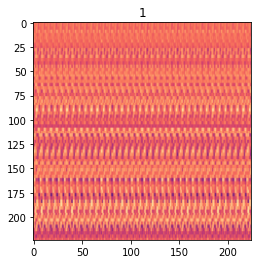

In [ ]:
import matplotlib.pyplot as plt
ToPILImage = transforms.Compose([
    transforms.ToPILImage()
])

for data, target in trainloader:
    index = 5
    print(data.shape)
    img = data[index]
    print(img.shape)
    pic = ToPILImage(img)
    plt.title(int(target[index]))
    plt.imshow(pic)
    plt.show()
    break

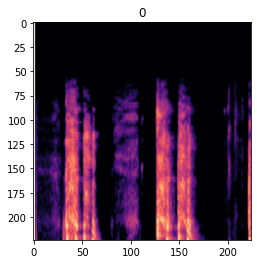

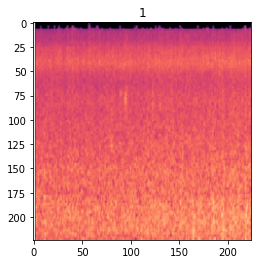

In [ ]:
import matplotlib.pyplot as plt
ToPILImage = transforms.Compose([
    transforms.ToPILImage()
])

for data, target in trainloader:
    img = data[4]
    pic = ToPILImage(img)
    plt.title(int(target[4]))
    plt.imshow(pic)
    plt.show()
    img = data[2]
    pic = ToPILImage(img)
    plt.title(int(target[2]))
    plt.imshow(pic)
    plt.show()
    break

In [ ]:
print(len(train[0]),len(valid[0]))

80 20


### Resnet

In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [ ]:
from torchvision.models import resnet50
model = resnet50(pretrained = False)

model.l1 = nn.Linear(2048, 256)
model.l2 = nn.Linear(256,  2)
nn.init.kaiming_normal_(model.l1.weight)
nn.init.kaiming_normal_(model.l2.weight)

model.fc = nn.Sequential(nn.BatchNorm1d(2048),
                         model.l1,
                         nn.Dropout(0.5),
                         nn.BatchNorm1d(256),
                         model.l2,
                         nn.Dropout(0.5)
                         )

model = model.to(device)

In [ ]:
n = 0
for data, target in train[0]:
    print(data.shape) # (batch, channel, width, height)
    break

data = data.to(device)

with torch.no_grad():
    y = model(data)
    print(y)
    print(np.argmax(y.cpu(), axis=1), target)

torch.Size([10, 3, 224, 224])
tensor([[-0.0000, -0.0000],
        [ 0.0000,  0.0000],
        [-3.3249, -0.0000],
        [ 0.0000,  0.0000],
        [-0.0000,  0.6838],
        [-1.6858, -1.4802],
        [ 0.0000,  1.3791],
        [ 2.9711,  0.0000],
        [ 0.0000,  2.7454],
        [-0.0000,  0.0000]], device='cuda:0')
tensor([0, 0, 1, 0, 1, 1, 1, 0, 1, 0]) tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 1])


In [ ]:
num=[]
for _, test_target in valid[0]:
  num += test_target
print(sum(num))

tensor(95)


In [ ]:
list_training_loss = []
list_test_loss = []

In [ ]:
def training_model(n_epochs, last_epoch, trainloader, testloader, seed, device, lr=0.001):
  seed_everything(seed)
  optimizer = torch.optim.Adam(model.parameters(), lr)
  criterion = nn.CrossEntropyLoss().to(device)

  for epoch in range(n_epochs):
    n_train, train_loss = 0,0
    model.train()
    for train_data, train_target in trainloader:
      train_data, train_target = train_data.to(device), train_target.to(device)
      y = model(train_data)
      del train_data
      loss = criterion(y, train_target).sum()
      train_loss += loss.data.cpu().numpy()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      n_train += 1
      del train_target
    
    if (epoch % 4 == 0) | (epoch == n_epochs-1):
      model.eval()
      n_test, test_loss = 0, 0
      correct, total, num_non, pred_non, TP  = 0, 0, 0, 0, 0
      for test_data, test_target in testloader:
        test_data = test_data.to(device)
        test_target = test_target.to(device)
        y_pred = model(test_data)
        idx_pred = torch.max(y_pred, 1)[1]
        del test_data
        loss = criterion(y_pred, test_target).sum()
        test_loss += loss.data.cpu().numpy()
        n_test += 1
        total += len(test_target)
        num_non += test_target.sum()
        pred_non += idx_pred.sum()
        correct += (idx_pred == test_target).sum()
        TP += (idx_pred == test_target).sum() - (idx_pred * test_target == 1).sum()

      accuracy = torch.round(correct * 100 / total, decimals=7)
      recall = torch.round(TP * 100 / (total - num_non), decimals=7)
      precision = torch.round(TP * 100 / (total - pred_non), decimals=7)
      f1score = torch.round(2 *(precision*recall) / (precision + recall), decimals=7)
      print('epoch {}th training loss: {} test loss: {}, accuracy: {}, precision: {}, recall: {}, f1 score: {}'.format(
            epoch + last_epoch + 1, round(train_loss / n_train, 7), round(test_loss / n_test, 7), accuracy, precision, recall,f1score))
      list_training_loss.append(train_loss / n_train)
      list_test_loss.append(test_loss / n_test)

In [ ]:
def test_score(model, testloader, device):
  model.eval()

  correct, total, num_non, pred_non, TP  = 0, 0, 0, 0, 0
  for test_data, test_target in testloader:
    test_data = test_data.to(device)
    test_target = test_target.to(device)
    y_pred = model(test_data)
    idx_pred = torch.max(y_pred, 1)[1]
    del test_data
    total += len(test_target)
    num_non += test_target.sum()
    pred_non += idx_pred.sum()
    correct += (idx_pred == test_target).sum()
    TP += (idx_pred == test_target).sum() - (idx_pred * test_target == 1).sum()

  accuracy = correct * 100 / total
  recall = TP * 100 / (total - num_non)
  precision = TP * 100 / (total - pred_non)
  f1score = 2 *(precision*recall) / (precision + recall)
  print('accuracy: {}, precision: {}, recall: {}, f1 score: {}'.format(accuracy, precision, recall, f1score))

## 학습

**1. 첫번째 train/valid로 50회 학습**

In [ ]:
training_model(50, 0, train[0], valid[0], 42, device, lr=0.001)

epoch 1th training loss: 0.9367384 test loss: 0.8122168, accuracy: 61.61616134643555, precision: 90.90908813476562, recall: 29.1262149810791, f1 score: 44.11764907836914
epoch 5th training loss: 0.6455828 test loss: 0.6262172, accuracy: 66.16161346435547, precision: 82.14286041259766, recall: 44.660194396972656, f1 score: 57.861637115478516
epoch 9th training loss: 0.574881 test loss: 0.428881, accuracy: 80.30303192138672, precision: 78.07017517089844, recall: 86.40776824951172, f1 score: 82.02765655517578
epoch 13th training loss: 0.5124941 test loss: 0.3939866, accuracy: 82.82828521728516, precision: 82.85713958740234, recall: 84.46601867675781, f1 score: 83.65384674072266
epoch 17th training loss: 0.531712 test loss: 0.3680525, accuracy: 83.33333587646484, precision: 84.31372833251953, recall: 83.49514770507812, f1 score: 83.9024429321289
epoch 21th training loss: 0.4933395 test loss: 0.3284086, accuracy: 85.3535385131836, precision: 79.36508178710938, recall: 97.0873794555664, f1 s

1-50


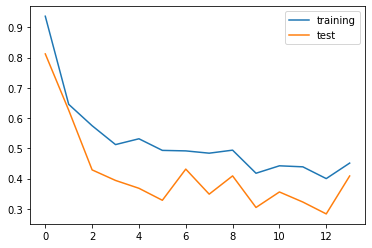

In [ ]:
import matplotlib.pyplot as plt

print('1-50')
plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()

**2. 두번째 train/valid로 50회 학습**

In [ ]:
training_model(50, 50, train[1], valid[1], 14, device, lr=0.001)

epoch 51th training loss: 0.5276077 test loss: 0.4404971, accuracy: 80.30303192138672, precision: 74.28571319580078, recall: 97.19625854492188, f1 score: 84.21052551269531
epoch 55th training loss: 0.514917 test loss: 0.4247048, accuracy: 80.8080825805664, precision: 80.0, recall: 85.98130798339844, f1 score: 82.88288879394531
epoch 59th training loss: 0.4597979 test loss: 0.4002254, accuracy: 84.34343719482422, precision: 84.54545593261719, recall: 86.91588592529297, f1 score: 85.71428680419922
epoch 63th training loss: 0.5393093 test loss: 0.3941188, accuracy: 81.3131332397461, precision: 83.01886749267578, recall: 82.24298858642578, f1 score: 82.62910461425781
epoch 67th training loss: 0.491275 test loss: 0.3462679, accuracy: 84.34343719482422, precision: 85.18518829345703, recall: 85.98130798339844, f1 score: 85.58139038085938
epoch 71th training loss: 0.4874438 test loss: 0.4453697, accuracy: 85.3535385131836, precision: 80.46875, recall: 96.26168060302734, f1 score: 87.6595687866

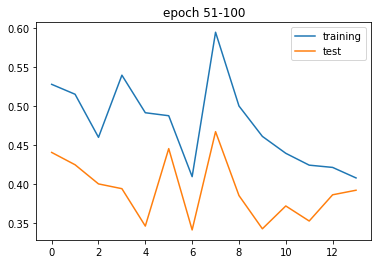

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss[14:], label='training')
plt.plot(list_test_loss[14:], label='test')
plt.title('epoch 51-100')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51201 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45572 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51201 missing from current font.
  font.set_text(s, 0, flags=flags)


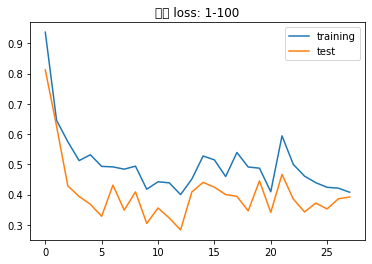

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.title('culti loss: 1-100')
plt.legend()
plt.show()

epoch 100 시점의 test score 계산

In [ ]:
# test score:
test_score(model, testloader, device)

accuracy: 83.5, precision: 80.43478393554688, recall: 83.14606475830078, f1 score: 81.76795959472656


**3. 세번째 train/valid로 50회 학습**

In [ ]:
training_model(50, 100, train[2], valid[2], 77, device, lr=0.001)

epoch 101th training loss: 0.4432588 test loss: 0.3166808, accuracy: 85.3535385131836, precision: 86.66666412353516, recall: 85.84906005859375, f1 score: 86.25592803955078
epoch 105th training loss: 0.4606946 test loss: 0.3718414, accuracy: 82.82828521728516, precision: 91.86046600341797, recall: 74.52830505371094, f1 score: 82.29167175292969
epoch 109th training loss: 0.4246595 test loss: 0.3415297, accuracy: 85.85858917236328, precision: 93.33333587646484, recall: 79.24528503417969, f1 score: 85.71428680419922
epoch 113th training loss: 0.5066385 test loss: 0.3909973, accuracy: 82.32323455810547, precision: 92.77108764648438, recall: 72.64151000976562, f1 score: 81.48148345947266
epoch 117th training loss: 0.4440229 test loss: 0.3484162, accuracy: 85.3535385131836, precision: 94.25287628173828, recall: 77.35848999023438, f1 score: 84.9740982055664
epoch 121th training loss: 0.389305 test loss: 0.3128337, accuracy: 87.8787841796875, precision: 89.42308044433594, recall: 87.73584747314

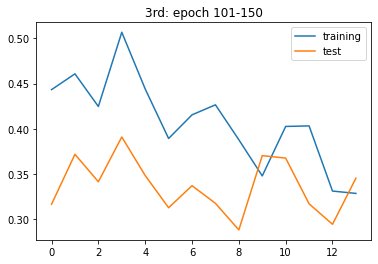

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss[28:], label='training')
plt.plot(list_test_loss[28:], label='test')
plt.title('3rd: epoch 101-150')
plt.legend()
plt.show()

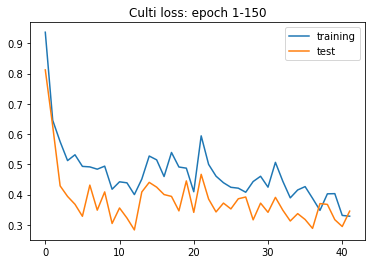

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.title('Culti loss: epoch 1-150')
plt.legend()
plt.show()

epoch 150 시점의 test score 계산

In [ ]:
# test score:
test_score(model, testloader, device)

accuracy: 86.5, precision: 93.05555725097656, recall: 75.28089904785156, f1 score: 83.22981262207031


**4. 네번째 train/valid로 50회 학습**

In [ ]:
training_model(50, 150, train[3], valid[3], 256, device, lr=0.001)

epoch 151th training loss: 0.4294453 test loss: 0.1881804, accuracy: 93.43434143066406, precision: 96.80850982666016, recall: 90.09900665283203, f1 score: 93.33332824707031
epoch 155th training loss: 0.3865913 test loss: 0.1939629, accuracy: 93.43434143066406, precision: 91.50943756103516, recall: 96.03960418701172, f1 score: 93.71981048583984
epoch 159th training loss: 0.3662673 test loss: 0.2250709, accuracy: 88.38383483886719, precision: 85.45454406738281, recall: 93.06930541992188, f1 score: 89.09952545166016
epoch 163th training loss: 0.3385344 test loss: 0.1794085, accuracy: 92.42424011230469, precision: 93.0, recall: 92.07920837402344, f1 score: 92.53731536865234
epoch 167th training loss: 0.2925196 test loss: 0.2138763, accuracy: 91.41413879394531, precision: 92.0, recall: 91.089111328125, f1 score: 91.54228973388672
epoch 171th training loss: 0.3343447 test loss: 0.1984872, accuracy: 89.89898681640625, precision: 90.09900665283203, recall: 90.09900665283203, f1 score: 90.09900

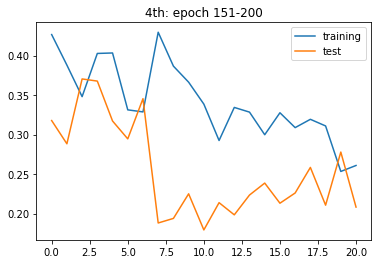

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss[35:], label='training')
plt.plot(list_test_loss[35:], label='test')
plt.title('4th: epoch 151-200')
plt.legend()
plt.show()

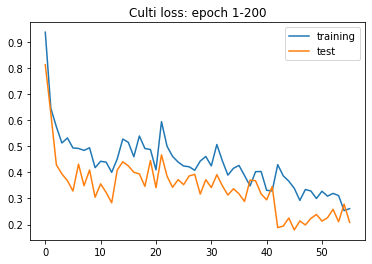

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.title('Culti loss: epoch 1-200')
plt.legend()
plt.show()

epoch 200 시점의 test score 계산

In [ ]:
#test score:
test_score(model, testloader, device)

accuracy: 86.5, precision: 79.80769348144531, recall: 93.25843048095703, f1 score: 86.01036071777344


In [ ]:
torch.save(model, 'model_cough200.pt') 

**5. 다섯번째 train/valid로 50회 학습**

In [ ]:
training_model(50, 200, train[4], valid[4], 122, device, lr=0.001)

epoch 201th training loss: 0.3441993 test loss: 0.1312747, accuracy: 92.92929077148438, precision: 89.7959213256836, recall: 95.65217590332031, f1 score: 92.63157653808594
epoch 205th training loss: 0.2833191 test loss: 0.1344305, accuracy: 93.43434143066406, precision: 89.89898681640625, recall: 96.73912811279297, f1 score: 93.19371795654297
epoch 209th training loss: 0.2825641 test loss: 0.1073968, accuracy: 95.9595947265625, precision: 95.65217590332031, recall: 95.65217590332031, f1 score: 95.65217590332031
epoch 213th training loss: 0.284928 test loss: 0.1514716, accuracy: 93.93939208984375, precision: 94.44444274902344, recall: 92.39130401611328, f1 score: 93.4065933227539
epoch 217th training loss: 0.290614 test loss: 0.196222, accuracy: 92.92929077148438, precision: 89.0, recall: 96.73912811279297, f1 score: 92.70832824707031
epoch 221th training loss: 0.3435066 test loss: 0.2808061, accuracy: 86.36363983154297, precision: 79.27928161621094, recall: 95.65217590332031, f1 score:

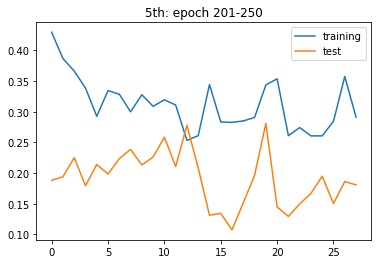

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss[42:], label='training')
plt.plot(list_test_loss[42:], label='test')
plt.title('5th: epoch 201-250')
plt.legend()
plt.show()

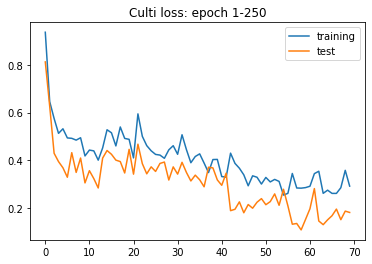

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.title('Culti loss: epoch 1-250')
plt.legend()
plt.show()

In [ ]:
# 최종 test score
test_score(model, testloader, device)

accuracy: 88.0, precision: 86.51685333251953, recall: 86.51685333251953, f1 score: 86.51685333251953


In [ ]:
torch.save(model, 'model_cough250.pt') 

In [ ]:
model.eval()
y_test = None
y_pred = None
for test_data, test_target in testloader:
    test_data = test_data.to(device)
    y = model(test_data)
    idx_pred = torch.max(y, 1)[1]
    if y_test == None:
        y_test = test_target
    else:
        y_test = torch.cat([y_test, test_target], dim=0)
    if y_pred == None:
        y_pred = idx_pred
    else:
        y_pred = torch.cat([y_pred, idx_pred], dim=0)

In [ ]:
y_pred

tensor([1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')

In [ ]:
y_test

tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test.detach().cpu(), y_pred.detach().cpu())

In [ ]:
print(confusion_matrix)

[[77 12]
 [12 99]]


In [ ]:
import itertools

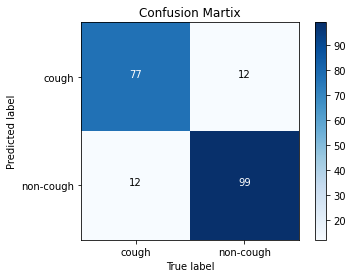

In [ ]:
plt.imshow(c_matrix, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
plt.title('Confusion Martix')
plt.colorbar()
plt.xticks([0,1],labels=['cough','non-cough'])
plt.yticks([0,1],labels=['cough','non-cough'])
plt.xlabel('True label')
plt.ylabel('Predicted label')

for i, j in itertools.product(range(2), range(2)):
  if confusion_matrix[i, j] < 50:
    plt.text(j, i, confusion_matrix[i, j], horizontalalignment="center", color="black")
  else:
    plt.text(j, i, confusion_matrix[i, j], horizontalalignment="center", color="white")
plt.show()